In [102]:
import os
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random
import uuid


In [103]:
class_ids = [
    "belcebu",
    "mazapan",
    "nina",
    "uxia"
]
colors = [
    (12,23,61),
   (187, 153, 61) ,
   (246, 113, 231),
   (41, 164, 65)
]

VAL_SPLIT = 0.08

class_mapping = dict(zip(range(len(class_ids)), class_ids))
color_mapping = dict(zip(range(len(class_ids)), colors))


path_dataset = "images-and-labels"
path_processed_dataset = "processed-images-and-labels"

annotations = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".txt")
    ]
)

image_paths = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".jpg")
    ]
)

assert len(image_paths) == len(annotations)

In [104]:


classes = []
boxes = []
for annotation_path in annotations:
	classes_for_img = []
	boxes_for_img = []
	classes_stringified = []
	with open(annotation_path) as annotation_file:
		for line in annotation_file.readlines():
			classes_for_img.append(int(line.split(' ')[0]))
			boxes_for_img.append([float(n) for n in line.strip().split(' ')[1:]])
	classes.append(classes_for_img)
	boxes.append(boxes_for_img)


images = []

for path in image_paths:
	image = cv2.imread(path)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	images.append(image)


assert len(classes) == len(boxes) == len(images)

In [105]:
not_nina_classes = []
not_nina_boxes = []
not_nina_images = []

nina_classes = []
nina_boxes = []
nina_images = []

nina_class = class_ids.index('nina')

for image, classes_per_img, boxes_per_img in zip(images,classes,boxes):
	if nina_class in classes_per_img:
		nina_classes.append(classes_per_img)
		nina_boxes.append(boxes_per_img)
		nina_images.append(image)
	else:
		not_nina_classes.append(classes_per_img)
		not_nina_boxes.append(boxes_per_img)
		not_nina_images.append(image)


In [106]:

transform = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.25),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.4),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [107]:
transformed_classes = []
transformed_boxes = []
transformed_images = []

for image, classes_per_image, boxes_per_image in zip(not_nina_images, not_nina_classes, not_nina_boxes):
		result = transform(image=image, bboxes=boxes_per_image, class_labels=classes_per_image)

		transformed_boxes.append(result['bboxes'])
		transformed_classes.append(result['class_labels'])
		transformed_images.append(result['image'])



In [108]:
def draw_bounding_boxes_on_image(image, bounding_boxes, class_labels):
    for box, label in zip(bounding_boxes, class_labels):
        x_norm, y_norm, width_norm, height_norm = box
        image_height, image_width, _ = image.shape

        x = int(x_norm * image_width)
        y = int(y_norm * image_height)
        width = int(width_norm * image_width)
        height = int(height_norm * image_height)
        x1 = int(x - width / 2)
        y1 = int(y - height / 2)
        x2 = int(x + width / 2)
        y2 = int(y + height / 2)

        cv2.rectangle(image, (x1, y1), (x2, y2), color_mapping[label], 2)
        cv2.putText(image, class_mapping[label], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color_mapping[label], 2)

def draw_images_grid(images, bounding_boxes_list, class_labels_list, grid_size=(2, 2)):
    rows, cols = grid_size
    grid_height = rows * images[0].shape[0]
    grid_width = cols * images[0].shape[1]
    grid = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)

    for row in range(rows):
        for col in range(cols):
            index = row * cols + col
            if index < len(images):
                image = images[index].copy()
                bounding_boxes = bounding_boxes_list[index]
                class_labels = class_labels_list[index]
                draw_bounding_boxes_on_image(image, bounding_boxes, class_labels)

                y_start = row * images[0].shape[0]
                y_end = y_start + images[0].shape[0]
                x_start = col * images[0].shape[1]
                x_end = x_start + images[0].shape[1]

                grid[y_start:y_end, x_start:x_end] = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.namedWindow("image_grid")
    cv2.imshow("image_grid", grid)
    cv2.waitKey(0)
    cv2.destroyWindow("image_grid")
    cv2.waitKey(1)

# Example usage
#draw_images_grid(transformed_images[:4], transformed_boxes[:4], transformed_classes[:4], grid_size=(2, 2))


In [109]:
all_classes = nina_classes + not_nina_classes + transformed_classes
all_boxes = nina_boxes + not_nina_boxes + transformed_boxes
all_images = nina_images + not_nina_images + transformed_images

assert len(all_classes) == len(all_boxes) == len(all_images)

print(f"Total count {len(all_images)} images")

Total count 1346 images


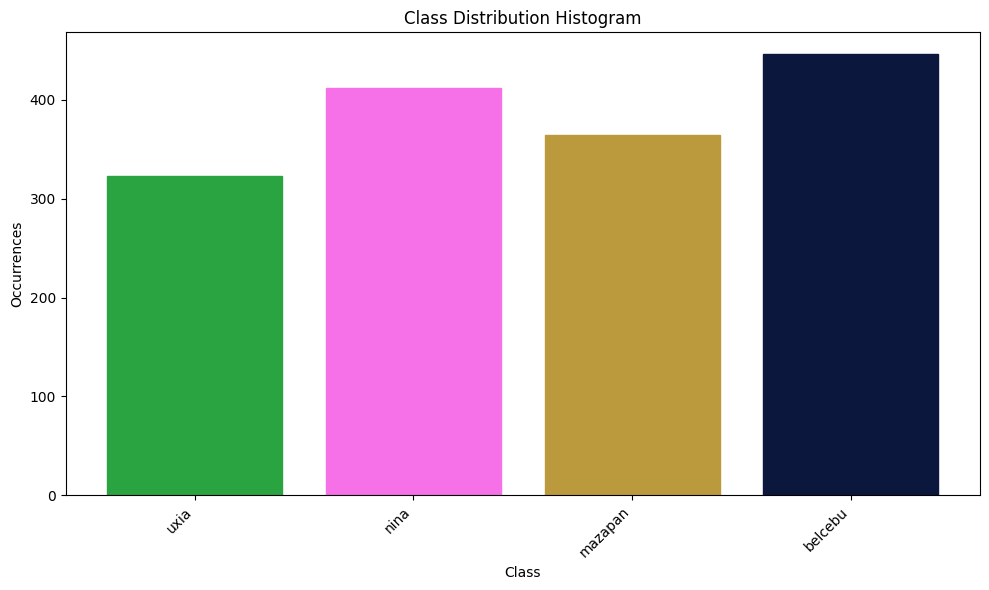

In [110]:
from collections import Counter

def plot_class_distribution(classes):
	flattened_classes = [n for c in classes for n in c]
	counted_classes = Counter(flattened_classes)
	class_counts = list(counted_classes.values())

	# Create a list of class labels in the order of their occurrences
	class_labels = [class_mapping[class_num] for class_num in counted_classes.keys()]


	# Create a histogram
	plt.figure(figsize=(10, 6))
	bars  =	plt.bar(class_labels, class_counts)
	class_colors_scaled = {class_num: (r/255.0, g/255.0, b/255.0) for class_num, (r, g, b) in color_mapping.items()}

	for class_num, bar in zip(counted_classes.keys(), bars):
		bar.set_color(class_colors_scaled[class_num])
	plt.xlabel('Class')
	plt.ylabel('Occurrences')
	plt.title('Class Distribution Histogram')
	plt.xticks(rotation=45, ha='right')

	# Display the plot
	plt.tight_layout()
	plt.show()

plot_class_distribution(all_classes)


In [111]:
def shuffle_lists(classes, boxes, images):
		combined = list(zip(classes, boxes, images))

		# Shuffle the combined list
		random.shuffle(combined)

		shuffled_classes, shuffled_boxes, shuffled_images = zip(*combined)

		shuffled_classes = list(shuffled_classes)
		shuffled_boxes = list(shuffled_boxes)
		shuffled_images = list(shuffled_images)

		return shuffled_classes,	shuffled_boxes, shuffled_images


shuffled_classes, shuffled_boxes, shuffled_images = shuffle_lists(all_classes,all_boxes,all_images)


#draw_images_grid(shuffled_images[:4], shuffled_boxes[:4], shuffled_classes[:4], grid_size=(2, 2))

In [112]:

val_num = int(VAL_SPLIT * len(shuffled_images))

val_images = shuffled_images[:val_num]
val_boxes = shuffled_boxes[:val_num]
val_classes = shuffled_classes[:val_num]

train_images = shuffled_images[val_num:]
train_boxes = shuffled_boxes[val_num:]
train_classes = shuffled_classes[val_num:]

def write_instances(images, boxes, classes, path):
	Path(path).mkdir(parents=True)

	for image, boxes_per_img, classes_per_img in zip(images,boxes, classes):
		img_path = Path(os.path.join(path, str(uuid.uuid4())))
		cv2.imwrite(str(img_path.with_suffix('.jpg')), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

		with open(img_path.with_suffix('.txt'), 'w') as file:
			file.writelines([f"{c} {' '.join([str(b) for b in box])}\n" for c, box in zip(classes_per_img, boxes_per_img)])
		
		
print(f"{len(train_images)} train images written")
print(f"{len(val_images)} validation images written")


1239 train images written
107 validation images written


In [113]:

try:
	shutil.rmtree(path_processed_dataset)
except FileNotFoundError:
	...

write_instances(val_images, val_boxes, val_classes, os.path.join(path_processed_dataset,'val'))
write_instances(train_images, train_boxes, train_classes, os.path.join(path_processed_dataset,'train'))

In [ ]:

from ultralytics import YOLO
from ultralytics import settings


model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

settings.update({'datasets_dir': './'})

# Train the model
model.train(data='./dataset.yml', imgsz=640)
